In [2]:

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Convergence

In [3]:
def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

In [96]:
n = 20
x = stats.norm.rvs(size=n)
mu_prior_mean = 0
mu_prior_sigma = 1

In [97]:
with pm.Model() as m:

    # traditional analysis
    mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)    
    y = pm.Normal('y', mu=mu, sigma=1, observed=x)
    
    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)  
    #bias against
    x_ = pm.Normal('x_', mu=mu_, sigma=1, shape=n)
    
    #one dimension
    #bias for (estimation)
    #x_ = pm.Normal('x_', mu=mu_+delta, sigma=1, shape=n)
    #x_ = pm.Normal('x_', mu=mu_-delta, sigma=1, shape=n)
    #x_ = pm.Normal('x_', mu=[mu_-delta,mu_+delta], sigma=1, shape=n) #might not working,just showing
    
    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_,0,1))
    
    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd", 
                                          normal_logp(mu_, posterior_mean, posterior_var**0.5))
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()
    
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_,1).sum())

In [98]:
with m:
    idata5000 = pm.sample(draws=5000)
    idata1000 = pm.sample(draws=1000)
    idata700 = pm.sample(draws=700)
    idata500 = pm.sample(draws=500)
    idata300 = pm.sample(draws=300)
    idata100 = pm.sample(draws=100)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━  71% 0:00:08 / 0:00:20

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, mu_, x_]


Output()

Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, mu_, x_]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


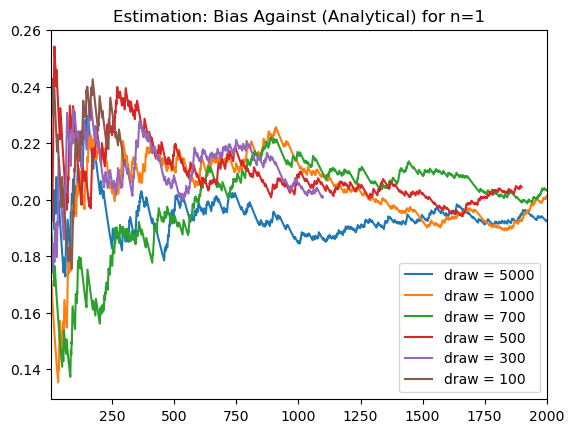

In [77]:
burn = 100

# draw = 5000
bias_against5000 = idata5000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against5000.shape[0]
bias_against_mci5000 = bias_against5000.cumsum()/np.arange(1,t+1)

# draw = 1000
bias_against1000 = idata1000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against1000.shape[0]
bias_against_mci1000 = bias_against1000.cumsum()/np.arange(1,t+1)

# draw = 700
bias_against700 = idata700.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against700.shape[0]
bias_against_mci700 = bias_against700.cumsum()/np.arange(1,t+1)

# draw = 500
bias_against500 = idata500.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against500.shape[0]
bias_against_mci500 = bias_against500.cumsum()/np.arange(1,t+1)

# draw = 300
bias_against300 = idata300.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against300.shape[0]
bias_against_mci300 = bias_against300.cumsum()/np.arange(1,t+1)

# draw = 100
bias_against100 = idata100.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against100.shape[0]
bias_against_mci100 = bias_against100.cumsum()/np.arange(1,t+1)


plt.plot(bias_against_mci5000[burn:], label = "draw = 5000"); 
plt.plot(bias_against_mci1000[burn:], label = "draw = 1000"); 
plt.plot(bias_against_mci700[burn:], label = "draw = 700"); 
plt.plot(bias_against_mci500[burn:], label = "draw = 500"); 
plt.plot(bias_against_mci300[burn:], label = "draw = 300"); 
plt.plot(bias_against_mci100[burn:], label = "draw = 100"); 
plt.title("Estimation: Bias Against (Analytical) for n={}".format(n))
plt.xlim(2, 2000)
plt.legend(loc='lower right')

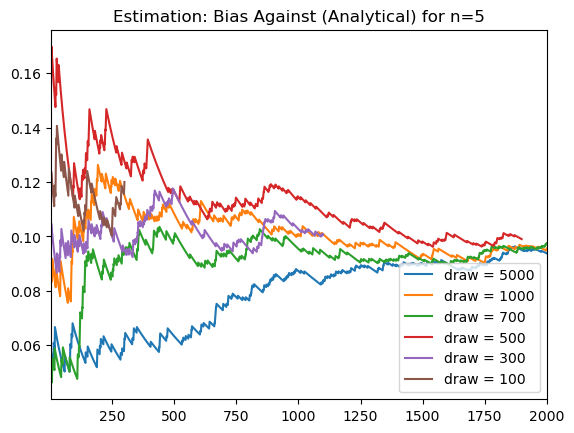

In [73]:
burn = 100

# draw = 5000
bias_against5000 = idata5000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against5000.shape[0]
bias_against_mci5000 = bias_against5000.cumsum()/np.arange(1,t+1)

# draw = 1000
bias_against1000 = idata1000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against1000.shape[0]
bias_against_mci1000 = bias_against1000.cumsum()/np.arange(1,t+1)

# draw = 700
bias_against700 = idata700.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against700.shape[0]
bias_against_mci700 = bias_against700.cumsum()/np.arange(1,t+1)

# draw = 500
bias_against500 = idata500.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against500.shape[0]
bias_against_mci500 = bias_against500.cumsum()/np.arange(1,t+1)

# draw = 300
bias_against300 = idata300.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against300.shape[0]
bias_against_mci300 = bias_against300.cumsum()/np.arange(1,t+1)

# draw = 100
bias_against100 = idata100.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against100.shape[0]
bias_against_mci100 = bias_against100.cumsum()/np.arange(1,t+1)


plt.plot(bias_against_mci5000[burn:], label = "draw = 5000"); 
plt.plot(bias_against_mci1000[burn:], label = "draw = 1000"); 
plt.plot(bias_against_mci700[burn:], label = "draw = 700"); 
plt.plot(bias_against_mci500[burn:], label = "draw = 500"); 
plt.plot(bias_against_mci300[burn:], label = "draw = 300"); 
plt.plot(bias_against_mci100[burn:], label = "draw = 100"); 
plt.title("Estimation: Bias Against (Analytical) for n={}".format(n))
plt.xlim(2, 2000)
plt.legend(loc='lower right')

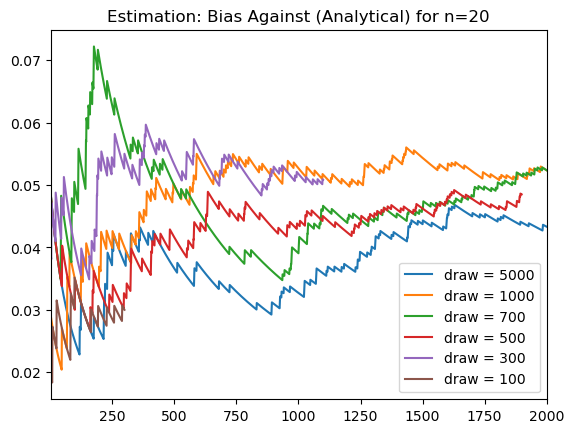

In [99]:
burn = 100

# draw = 5000
bias_against5000 = idata5000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against5000.shape[0]
bias_against_mci5000 = bias_against5000.cumsum()/np.arange(1,t+1)

# draw = 1000
bias_against1000 = idata1000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against1000.shape[0]
bias_against_mci1000 = bias_against1000.cumsum()/np.arange(1,t+1)

# draw = 700
bias_against700 = idata700.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against700.shape[0]
bias_against_mci700 = bias_against700.cumsum()/np.arange(1,t+1)

# draw = 500
bias_against500 = idata500.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against500.shape[0]
bias_against_mci500 = bias_against500.cumsum()/np.arange(1,t+1)

# draw = 300
bias_against300 = idata300.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against300.shape[0]
bias_against_mci300 = bias_against300.cumsum()/np.arange(1,t+1)

# draw = 100
bias_against100 = idata100.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against100.shape[0]
bias_against_mci100 = bias_against100.cumsum()/np.arange(1,t+1)


plt.plot(bias_against_mci5000[burn:], label = "draw = 5000"); 
plt.plot(bias_against_mci1000[burn:], label = "draw = 1000"); 
plt.plot(bias_against_mci700[burn:], label = "draw = 700"); 
plt.plot(bias_against_mci500[burn:], label = "draw = 500"); 
plt.plot(bias_against_mci300[burn:], label = "draw = 300"); 
plt.plot(bias_against_mci100[burn:], label = "draw = 100"); 
plt.title("Estimation: Bias Against (Analytical) for n={}".format(n))
plt.xlim(2, 2000)
plt.legend(loc='lower right')

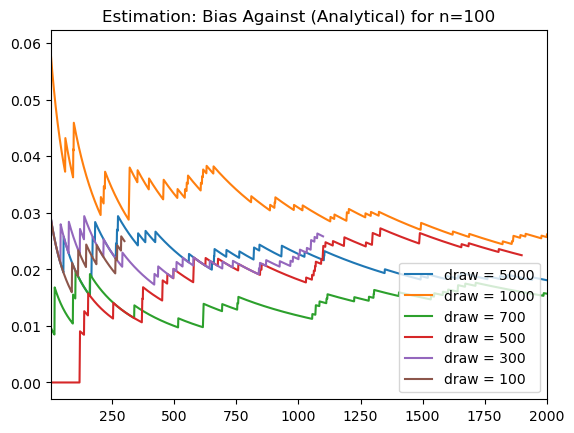

In [95]:
burn = 100

# draw = 5000
bias_against5000 = idata5000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against5000.shape[0]
bias_against_mci5000 = bias_against5000.cumsum()/np.arange(1,t+1)

# draw = 1000
bias_against1000 = idata1000.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against1000.shape[0]
bias_against_mci1000 = bias_against1000.cumsum()/np.arange(1,t+1)

# draw = 700
bias_against700 = idata700.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against700.shape[0]
bias_against_mci700 = bias_against700.cumsum()/np.arange(1,t+1)

# draw = 500
bias_against500 = idata500.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against500.shape[0]
bias_against_mci500 = bias_against500.cumsum()/np.arange(1,t+1)

# draw = 300
bias_against300 = idata300.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against300.shape[0]
bias_against_mci300 = bias_against300.cumsum()/np.arange(1,t+1)

# draw = 100
bias_against100 = idata100.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against100.shape[0]
bias_against_mci100 = bias_against100.cumsum()/np.arange(1,t+1)


plt.plot(bias_against_mci5000[burn:], label = "draw = 5000"); 
plt.plot(bias_against_mci1000[burn:], label = "draw = 1000"); 
plt.plot(bias_against_mci700[burn:], label = "draw = 700"); 
plt.plot(bias_against_mci500[burn:], label = "draw = 500"); 
plt.plot(bias_against_mci300[burn:], label = "draw = 300"); 
plt.plot(bias_against_mci100[burn:], label = "draw = 100"); 
plt.title("Estimation: Bias Against (Analytical) for n={}".format(n))
plt.xlim(2, 2000)
plt.legend(loc='lower right')

# Beta Model

## Bias Against

In [9]:
alpha0 = 4
beta0 = 4
n = 20  # number of observations
theta0 = 0.5
x = np.random.binomial(1, theta0,n)


In [10]:
def beta_logp(a, b, x):
    return (a - 1) * pm.math.log(x) + (b - 1) * pm.math.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

In [11]:
with pm.Model() as m:
    
    # Traditional analysis
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    y = pm.Bernoulli("y", p=theta, observed=x)
    
    # "empty model" MCMC sample over prior and prior predictive data
    theta_ = pm.Beta("theta_", alpha=alpha0, beta=beta0)

    # Bias against
    x_ = pm.Bernoulli("x_", p=theta_, shape=n)
    
    # Prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", beta_logp(alpha0, beta0, theta_))

    # Posterior calculations
    posterior_alpha = n * np.mean(x) + alpha0
    posterior_beta = n * (1 - np.mean(x)) + beta0
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd", beta_logp(posterior_alpha, posterior_beta, theta_))

    # log RB ratio
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd - prior_prior_pd)
    
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", beta_logp(posterior_alpha, posterior_beta, theta_).sum())
    
    # Sample from the model
    idata = pm.sample(1000, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta, theta_]
>BinaryGibbsMetropolis: [x_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
C:\Users\23639\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


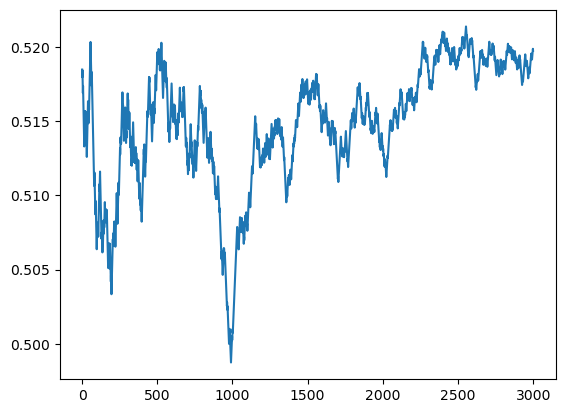

In [12]:
bias_against = idata.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:]); 

## Simulation

In [13]:
def bernoulli_logp(p, x):
    return x * np.log(p) + (1 - x) * np.log(1 - p)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


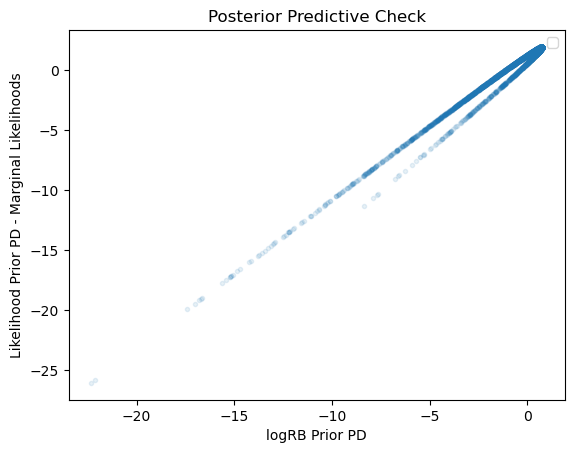

In [18]:
use = 10000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape) + [use])
for i, m in enumerate(idata.posterior['theta_'].values.ravel()[:use]):
    marginal_likelihoods[:, :, :, i] = bernoulli_logp(m, idata.posterior['x_'].values)  # Getting likelihoods for each x_ under each theta_

marginal_likelihoods_ = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel())  # Summing the log likelihoods and then taking the average over the parameter samples

plt.plot(idata.posterior['logRB_prior_pd'].values.ravel(), 
         idata.posterior['likelihood_prior_pd'].values.ravel() - marginal_likelihoods_, '.', alpha=0.1)
plt.xlabel('logRB Prior PD')
plt.ylabel('Likelihood Prior PD - Marginal Likelihoods')
plt.title('Posterior Predictive Check')
plt.legend()
plt.show()

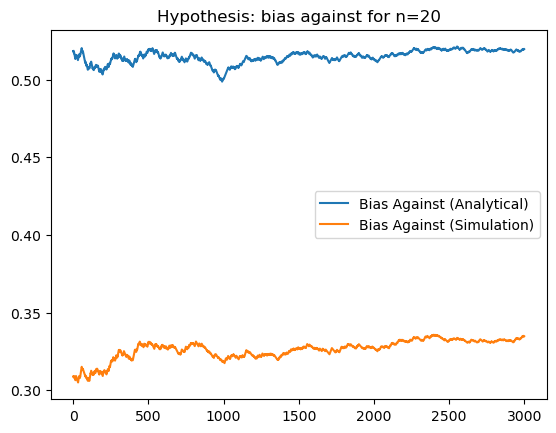

In [20]:
# Analytics
bias_against = idata.posterior['logRB_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')

# Simulation
bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods_) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')

plt.title("Hypothesis: bias against for n={}".format(n))
plt.legend()

## Bias in Flavor for Beta Model

In [4]:
alpha0 = 4
beta0 = 4
n = 20  # number of observations
delta = 0.05
theta0 = 0.5
data1 = np.random.binomial(1, theta0+delta, n)
data2 = np.random.binomial(1,theta0-delta, n)


In [6]:
with pm.Model() as minflavor:
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)
   
    prior_prior_pd = pm.Deterministic("prior_prior_pd", beta_logp(alpha0, beta0, theta))

    # Posterior calculations
    posterior_alpha1 = n * np.mean(data1) + alpha0
    posterior_beta1 = n * (1 - np.mean(data1)) + beta0
    posterior_prior_pd1 = pm.Deterministic("posterior_prior_pd1", beta_logp(posterior_alpha1, posterior_beta1, theta))

    posterior_alpha2 = n * np.mean(data2) + alpha0
    posterior_beta2 = n * (1 - np.mean(data2)) + beta0
    posterior_prior_pd2 = pm.Deterministic("posterior_prior_pd2", beta_logp(posterior_alpha2, posterior_beta2, theta))

    # log RB ratio
    logRB_prior_pd1 = pm.Deterministic("logRB_prior_pd1", posterior_prior_pd1 - prior_prior_pd)
    logRB_prior_pd2 = pm.Deterministic("logRB_prior_pd2", posterior_prior_pd2 - prior_prior_pd)

    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", beta_logp(posterior_alpha1, posterior_beta1, theta).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", beta_logp(posterior_alpha2, posterior_beta2, theta).sum())
    
    # Sample from the model
    inflavor = pm.sample(1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>BinaryGibbsMetropolis: [xl_, xu_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


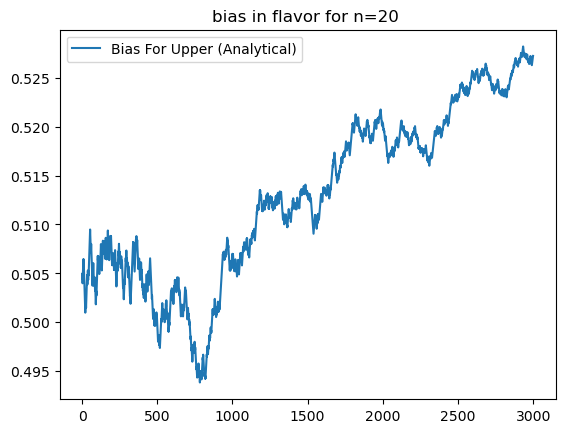

In [7]:
bias_inflavor = inflavor.posterior['logRB_prior_pd1'].values.ravel()>=0
t = bias_inflavor.shape[0]
bias_inflavor_mci = bias_inflavor.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_inflavor_mci[burn:], label='Bias For Upper (Analytical)')
plt.title("bias in flavor for n={} ".format(n))
plt.legend()

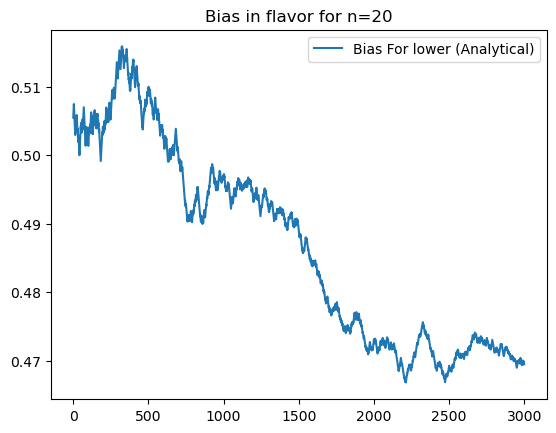

In [8]:
bias_inflavor = inflavor.posterior['logRB_prior_pd2'].values.ravel()>=0
t = bias_inflavor.shape[0]
bias_inflavor_mci = bias_inflavor.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_inflavor_mci[burn:], label='Bias For lower (Analytical)')
plt.title("Bias in flavor for n={}".format(n))
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


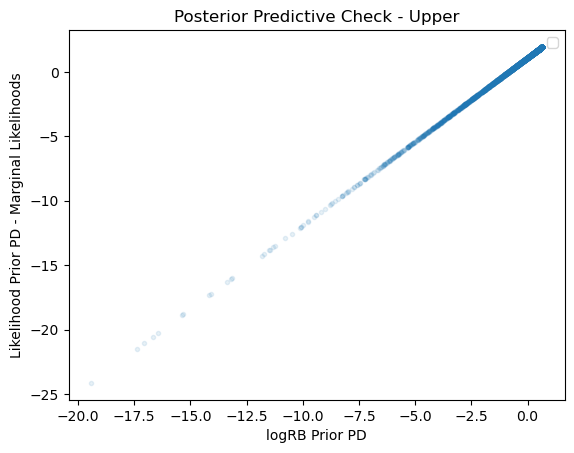

In [26]:
use = 10000
marginal_likelihoods1 = np.zeros(list(inflavor.posterior['xu_'].values.shape) + [use])
for i, m in enumerate(inflavor.posterior['theta'].values.ravel()[:use]):
    marginal_likelihoods1[:, :, :, i] = bernoulli_logp(m, inflavor.posterior['xu_'].values)  # Getting likelihoods for each x_ under each theta_

marginal_likelihoods_1 = np.log(np.exp(marginal_likelihoods1.sum(axis=2)).mean(axis=-1).ravel())  # Summing the log likelihoods and then taking the average over the parameter samples

plt.plot(inflavor.posterior['logRB_prior_pd1'].values.ravel(), 
         inflavor.posterior['likelihood_prior_pd1'].values.ravel() - marginal_likelihoods_1, '.', alpha=0.1)
plt.xlabel('logRB Prior PD')
plt.ylabel('Likelihood Prior PD - Marginal Likelihoods')
plt.title('Posterior Predictive Check - Upper')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


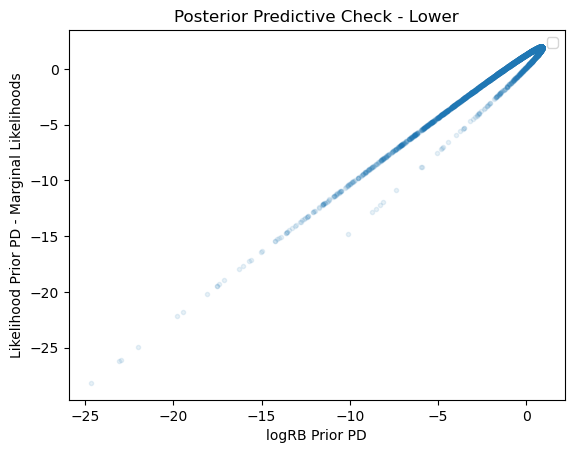

In [28]:
use = 10000
marginal_likelihoods2 = np.zeros(list(inflavor.posterior['xl_'].values.shape) + [use])
for i, m in enumerate(inflavor.posterior['theta'].values.ravel()[:use]):
    marginal_likelihoods2[:, :, :, i] = bernoulli_logp(m, inflavor.posterior['xl_'].values)  # Getting likelihoods for each x_ under each theta_

marginal_likelihoods_2 = np.log(np.exp(marginal_likelihoods2.sum(axis=2)).mean(axis=-1).ravel())  # Summing the log likelihoods and then taking the average over the parameter samples

plt.plot(inflavor.posterior['logRB_prior_pd2'].values.ravel(), 
         inflavor.posterior['likelihood_prior_pd2'].values.ravel() - marginal_likelihoods_2, '.', alpha=0.1)
plt.xlabel('logRB Prior PD')
plt.ylabel('Likelihood Prior PD - Marginal Likelihoods')
plt.title('Posterior Predictive Check - Lower')
plt.legend()
plt.show()

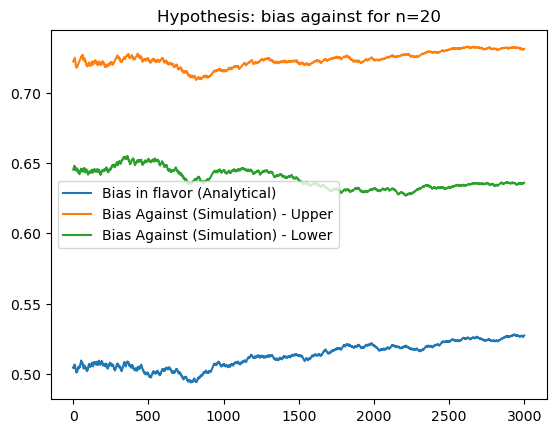

In [36]:
# Analytics
bias_inflavor = inflavor.posterior['logRB_prior_pd1'].values.ravel() >= 0
t = bias_inflavor.shape[0]
burn = 1000
bias_inflavor_mci = bias_inflavor.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_mci[burn:], label='Bias in flavor (Analytical)')

# Simulation
bias_inflavor_ml1 = (inflavor.posterior['likelihood_prior_pd1'].values.ravel()-marginal_likelihoods_1) >= 0
bias_inflavor_ml_mci1 = bias_inflavor_ml1.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_ml_mci1[burn:], label='Bias Against (Simulation) - Upper')
bias_inflavor_ml2 = (inflavor.posterior['likelihood_prior_pd2'].values.ravel()-marginal_likelihoods_2) >= 0
bias_inflavor_ml_mci2 = bias_inflavor_ml2.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_ml_mci2[burn:], label='Bias Against (Simulation) - Lower')

plt.title("Hypothesis: bias against for n={}".format(n))
plt.legend()

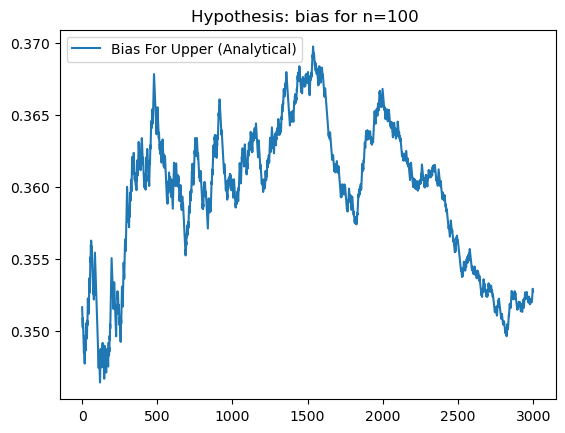

In [38]:
bias_against = inflavor.posterior['logRB_prior_pd1'].values.ravel()>=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:], label='Bias For Upper (Analytical)')
plt.title("Bias in flavor for n={} ".format(n))
plt.legend()

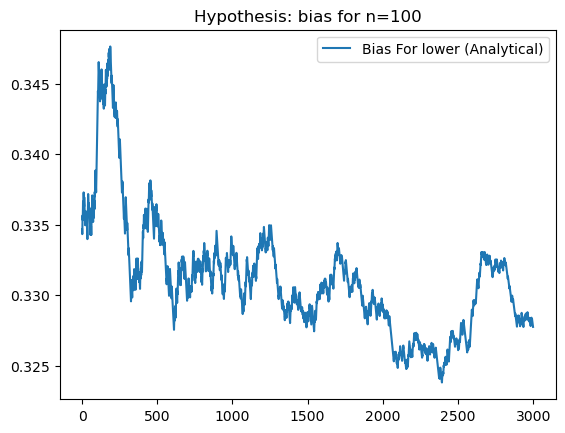

In [39]:
bias_against = inflavor.posterior['logRB_prior_pd2'].values.ravel()>=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:], label='Bias For lower (Analytical)')
plt.title("Bias in flavor for n={}".format(n))
plt.legend()